In [16]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import lmdb
from udls.generated import AudioExample
import IPython.display as ipd
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import logging
import torchaudio
import librosa
from typing import Callable, Optional
import warnings

logger = logging.getLogger(__name__)
logging.basicConfig(
    format="[%(asctime)s] %(levelname)s(%(name)s)\t%(message)s", level=logging.INFO
)

device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info("device: %s", device)

[2024-01-01 19:57:39,342] INFO(root)	device: cuda


In [17]:
# utils
plt.rcParams["savefig.bbox"] = "tight"


def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(
        librosa.power_to_db(specgram),
        origin="lower",
        aspect="auto",
        interpolation="nearest",
    )

In [18]:
# dataset definition
class LoopDataset(torch.utils.data.Dataset):
    SAMPLING_RATE = 44100
    SIZE_SAMPLES = 65536

    def __init__(self, db_path: str) -> None:
        super().__init__()

        self._db_path = db_path

        self.env = lmdb.open(self._db_path, lock=False)

        with self.env.begin(write=False) as txn:
            self.keys = list(txn.cursor().iternext(values=False))

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx: int):
        with self.env.begin(write=False) as txn:
            ae = AudioExample.FromString(txn.get(self.keys[idx]))

        buffer = ae.buffers["waveform"]
        assert buffer.precision == AudioExample.Precision.INT16
        assert buffer.sampling_rate == self.SAMPLING_RATE

        audio = torch.frombuffer(buffer.data, dtype=torch.int16)
        audio = audio.float() / (2**15 - 1)
        assert len(audio) == self.SIZE_SAMPLES

        return audio


# get 5 random examples
dataset = LoopDataset(db_path="../../data/loops/")
for i in np.random.randint(len(dataset), size=5):
    print(f"example #{i}")
    ipd.display(ipd.Audio(dataset[i], rate=LoopDataset.SAMPLING_RATE))

example #10402


example #1922


example #9214


example #6988


example #8857


d:\Documents\ATIAM\Temporal-Audio-VAE\.venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (50) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([50, 328]) torch.Size([201, 328])


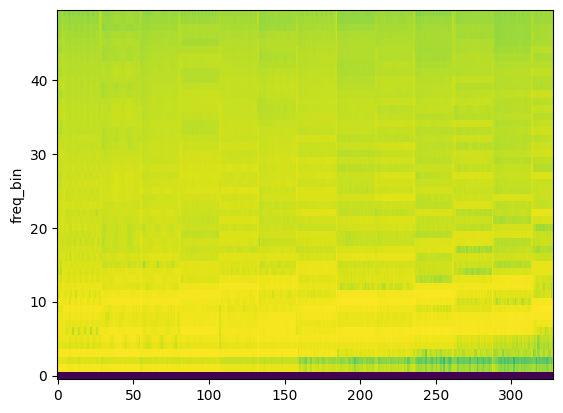

In [22]:
# transform definition


# extended from torchaudio.transform.MelSpectrogram
class CustomTransform(nn.Module):
    __constants__ = [
        "sample_rate",
        "n_fft",
        "win_length",
        "hop_length",
        "pad",
        "power",
        "normalized",
        "n_mels",
        "f_max",
        "f_min",
        "norm",
        "mel_scale",
        "n_stft",
    ]

    def __init__(
        self,
        sample_rate: int = 16000,
        n_fft: int = 400,
        win_length: Optional[int] = None,
        hop_length: Optional[int] = None,
        f_min: float = 0.0,
        f_max: Optional[float] = None,
        pad: int = 0,
        n_mels: int = 128,
        window_fn: Callable[..., torch.Tensor] = torch.hann_window,
        normalized: bool = False,
        wkwargs: Optional[dict] = None,
        center: bool = True,
        pad_mode: str = "reflect",
        norm: Optional[str] = None,
    ):
        super(CustomTransform, self).__init__()

        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.win_length = win_length if win_length is not None else n_fft
        self.hop_length = hop_length if hop_length is not None else self.win_length // 2
        self.pad = pad
        self.normalized = normalized
        self.n_mels = n_mels  # number of mel frequency bins
        self.f_max = f_max
        self.f_min = f_min
        self.norm = norm
        self.n_stft = self.n_fft // 2 + 1

        self.spectrogram = torchaudio.transforms.Spectrogram(
            n_fft=self.n_fft,
            win_length=self.win_length,
            hop_length=self.hop_length,
            pad=self.pad,
            window_fn=window_fn,
            power=None,  # get complex spectrogram
            normalized=self.normalized,
            wkwargs=wkwargs,
            center=center,
            pad_mode=pad_mode,
            onesided=True,
        )
        self.mel_scale = torchaudio.transforms.MelScale(
            n_mels=self.n_mels,
            sample_rate=self.sample_rate,
            f_min=self.f_min,
            f_max=self.f_max,
            n_stft=self.n_stft,
            norm=self.norm,
            mel_scale="htk",
        )
        self.inv_mel_scale = torchaudio.transforms.InverseMelScale(
            n_mels=self.n_mels,
            sample_rate=self.sample_rate,
            f_min=self.f_min,
            f_max=self.f_max,
            n_stft=self.n_stft,
            norm=self.norm,
            mel_scale="htk",
            driver="gelss",
        )
        self.inv_spectrogram = torchaudio.transforms.InverseSpectrogram(
            n_fft=self.n_fft,
            win_length=self.win_length,
            hop_length=self.hop_length,
            pad=self.pad,
            window_fn=window_fn,
            normalized=self.normalized,
            wkwargs=wkwargs,
            center=center,
            pad_mode=pad_mode,
            onesided=True,
        )

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        specgram = self.spectrogram(waveform)  # Dimension: (…, freq, time)
        mag, phase = torch.abs(specgram), torch.angle(specgram)
        mel_specgram = self.mel_scale(mag)  # dimension: (…, n_mels, time)
        log_mel_specgram = torch.log(1 + mel_specgram)
        return log_mel_specgram, phase

    def backward(
        self, log_mel_specgram: torch.Tensor, phase: torch.Tensor
    ) -> torch.Tensor:
        mel_specgram = torch.exp(log_mel_specgram) - 1
        mag = self.inv_mel_scale(mel_specgram)
        specgram = mag * torch.exp(1j * phase)  # TODO: reconstruct phase
        waveform = self.inv_spectrogram(specgram)
        return waveform


ipd.display(ipd.Audio(dataset[7809], rate=LoopDataset.SAMPLING_RATE))
t = CustomTransform(sample_rate=LoopDataset.SAMPLING_RATE, n_mels=50)
spec, phase = t.forward(dataset[7809])
print(spec.shape, phase.shape)
plot_spectrogram(spec)
transformed_transformed = t.backward(spec, phase)
ipd.display(ipd.Audio(transformed_transformed, rate=LoopDataset.SAMPLING_RATE))